# Exponential Smoothing Models

---
This notebook explores double and triple exponential smoothing models in order to forecast Bitcoin price. 

The following description of AIC and RSS is the same as the ARIMA notebook's description:

The metrics being used to compare the models are their AIC scores as Residual Sum of Squares (RSS). The AIC (Akaie Information Criterion) measures how well the model measures reality. This is explaining how well the model works on the training data (for those more familiar, this can be thought of as our training score). The RSS is the chosen error term as it harshly punishes incorrect forecasts, and does so in a more extreme way than other error metrics (such as MSE, MAE or RMSE). This is explaining how well the model works on the testing data (for those more familiar, this can be thought of as our testing score).

To begin, a baseline Double Exponential Smoothing model will be built, followed by a gridsearch helper function to search over specified hyperparameters. For the baseline Double Exponential Smoothing model, the baseline hyperparamteres are 0.75 for both the exponential smoothing and slope. The smoothing level determines how much weight should be given to the most recent values. The exponential smoothing level is between 0 and 1 with 1 meaning the previous value is the next value and 0 means the most recent value has no impact on the next value. The ACF chart helps explain this: because the highest autocorrelation was seen in once lagged values, we can assume that the smoothing level should be closer to 1. The smoothing slope determines how much of the underlying trend needs to be smoothed out. It has a similar scale as the smoothing level (0 to 1) with the value of 1 meaning more smoothing is required. Because we were able to confirm the trend in the ACF chart, the smoothing level should be above 0, but determining what the appropriate level is will need to be searched over.

Then, a baseline Triple Exponential Smoothing model will be built, followed by a gridsearch helper function to search over specified hyperparameters. For the baseline Triple Exponential Smoothing model, the baseline hyperparameters are seasonal_period: 30, seasonal: 'multiplicative', trend: 'multiplicative', and damped: True. The seasonal period set to 30 is from the seasonality being seen at the monthly level. Both the seasonal and trend being set to 'multiplicative' also stems from the EDA and the fact that the data has an exponential trend. The damped argument is being set to true as the expectation is if it is not set to true then the forecast will continue on to infinity which is unrealistic.

Two notes regarding the data: unlike with the ARIMA models, the exponential smoothing models will just use the normal data instead of the logged versions of the data, and the data does not need to be differenced. The trend argument in both the Double and Triple Exponential Smoothing models allows normal/non-logged data. This argument will automatically tell the model that the data has an exponential trend. Additionally, these exponential models do not require the data to be stationary which means differncing does not need to be applied to the data.

The following note regarding the GridSearched cells is the same as in the ARIMA notebook: 

Notebook note: The cells that run the various gridsearches have been commented out in this notebook as they can take some time to complete. The outputs of the completed GridSearches are also in those cells as comments but should someone choose to run the GridSearches themselves those lines of code will need to be uncommented. Each of the optimized models were built out and can be run.

## Table of Contents

- **[Import Libraries & DataFrame](#1)**
- **[Baseline Double Exponential Smoothing Model](#2)**
- **[Double Exponential Smoothing Model GridSearch](#3)**
- **[Baseline Triple Exponential Smoothing Model](#4)**
- **[Triple Exponential Smoothing Model GridSearch](#5)**
- **[Forward Forecast: Holt Model](#6)**

<a id="1"></a>
## Import Libraries and Data

In [187]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

from sklearn import metrics
from statsmodels.tsa.api import Holt
from statsmodels.tsa.holtwinters import ExponentialSmoothing

import warnings
warnings.filterwarnings('ignore')

In [2]:
# import daily data
daily = pd.read_csv('./data/daily_clean.csv')

# change dat col to datetime
daily['date'] = pd.to_datetime(daily['date'])

# set date as index
daily.set_index('date', inplace=True)

# sort by index
daily.sort_index(inplace=True)

# confirm df
daily.head()

,high,low,open,close,volume
Date,,,,,
2013-04-29 23:59:00,147.488007,134.000000,134.444000,144.539993,0.0
2013-04-30 23:59:00,146.929993,134.050003,144.000000,139.000000,0.0
2013-05-01 23:59:00,139.889999,107.720001,139.000000,116.989998,0.0
2013-05-02 23:59:00,125.599998,92.281898,116.379997,105.209999,0.0
2013-05-03 23:59:00,108.127998,79.099998,106.250000,97.750000,0.0


In [189]:
# set training and testing ranges
train = daily['close'][:-90]
test = daily['close'][-90:]

<a id="2"></a>
## Baseline Double Exponential Smoothing Model
___
This section builds out a baseline Double Exponential Smoothing model (aka Holt). The parameters being used will be exponential and damped set to True and both the exponential trend and slope set to 0.75. Exponential should be set to true becasue the data has an exponential trend. Damped will make the forecast level off instead of just continuing up to infinity. The smoothing level determines how much weight should be given to the most recent values. The smoothing slope determines how much of the underlying trend needs to be smoothed out. 

In [190]:
# insatiate and fit the model
baseline_holt = Holt(train, 
                   exponential=True, 
                   damped_trend=True, 
                   initialization_method='estimated').fit(0.75, 0.75)

# print aic score
print(f'Baseline Holt Model AIC Score: {baseline_holt.aic}')

# generate forecasts for this model
baseline_holt_fcast = baseline_holt.forecast(len(test))

# print RSS score
print(f'Baseline Holt Model RSS Score: {metrics.mean_squared_error(test, baseline_holt_fcast) * len(test)}')

Baseline Holt Model AIC Score: 32462.821160963063
Baseline Holt Model RSS Score: 3677604434.390559


The Baseline Double Exponential Smoothing (Holt) Model is a significant improvement on the SARIMA model that was previously considered the best model thus far. The RSS for this baseline model is 3,677,604,434.390559.

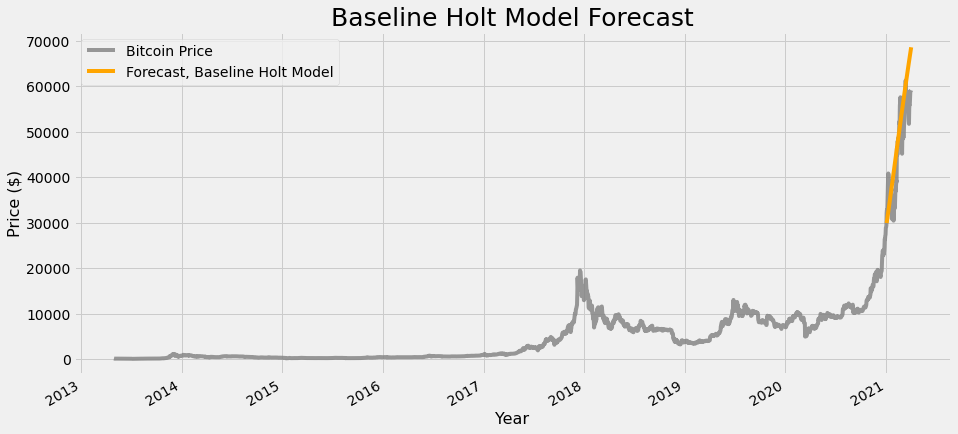

In [191]:
# plot true values
daily['close'].plot(alpha = 0.8, color='grey', label='Bitcoin Price', legend=True, figsize=(14, 7))

# plot forecasted values
baseline_holt_fcast.plot(color='orange', label='Forecast, Baseline Holt Model', legend=True)

# add title/x/y labels
plt.title('Baseline Holt Model Forecast', fontsize=25)
plt.xlabel('Year', fontsize=16)
plt.ylabel('Price ($)', fontsize=16);

The baseline Holt model's forecast is a significant improvement from the ARIMA/SARIMA models' forecasts; however, the baseline Holt model is overestimating the price of Bitcoin. Based on this model the price of Bitcoin should be approaching $70,000 / coin. This unfortunately is not the case, but perhaps adjusting some of the parameters will provide a better forecast.

<a id="3"></a>
## Double Exponential Smoothing Model GridSearch
___
This section built a helper function that will GridSearch over the Holt model's hyperparameters. This function will be used twice: once to optimize for AIC and once to optimize for RSS. 

The parameters being searched over in this gridsearch are exponential smoothing, slope, trend, damped, and optimized. The exponential smoothing and slope models need to be searched over values between 0 and 1. The expectation is that the best value will be closer to 1 than 0 in this situation based on the baseline model. The trend will be checked if this model is better at forecasting the Bitcoin price if the trend is linear or exponential. Damped was set to true in the baseline model and will be tested if it is better set to true or false. Finally optimized is set to true by default and the gridsearch will check if this is better set to true or false. 

In [192]:
# run a gridsearch over the smoothing level and slope params, trend, and damped hyperparams
smoothing = np.linspace(0, 1, 20)
slope = np.linspace(0, 1, 20)
trend = damped = optimized = [True, False]

# create a gridsearch optimizing for aic
def holt_gs(train, test, optimization='AIC'):
    # set initial values
    best_aic = 1000000000000
    best_rss = 1000000000000
    best_smoothing = 0.75
    best_slope = 0.75
    best_trend = _
    best_damped = _
    best_optimized = _
    
    # set condition based on optimization
    if optimization == 'AIC':
    
        # loop through each smoothing val
        for i in smoothing:

            # loop through each slope vl
            for j in slope:

                # loop through each trend
                for e in trend:

                    # loop through damped
                    for d in damped:

                        # loop through optimized
                        for o in optimized:

                            try:
                                # insatiate and fit the model once
                                model = Holt(train, 
                                             exponential = e, 
                                             damped_trend = d, 
                                             initialization_method='estimated').fit(i, j, optimized=o)

                                # generate forecast
                                fcast = model.forecast(len(test))

                                # generate rmse for first model
                                rss = metrics.mean_squared_error(test, fcast) * len(test)

                                # condition if aic is lower
                                if model.aic < best_aic:
                                    best_aic = model.aic
                                    best_rss = rss
                                    best_smoothing = i
                                    best_slope = j
                                    best_trend = e
                                    best_damped = d
                                    best_optimized = o

                                # print statement for each fit
                                print(f"RSS of Holt's model with smoothing {i}, slope {j}, exponential {e}, damped {d}, optimized{o}, was {rss}")

                            except:
                                continue

        # print model params for lowest aic
        print(f"The best params for a Holt's model optimizing for AIC: smoothing {best_smoothing}, slope {best_slope}, exponential {best_trend}, damped {best_damped}, optimized {best_optimized} for a rss of {best_rss} and AIC of {best_aic}")
        
    # set condition for RSS optimization
    elif optimization == 'RSS':
        
        # loop through each smoothing val
        for i in smoothing:

            # loop through each slope vl
            for j in slope:

                # loop through each trend
                for e in trend:

                    # loop through damped
                    for d in damped:

                        # loop through optimized
                        for o in optimized:

                            try:
                                # insatiate and fit the model once
                                model = Holt(train, 
                                             exponential = e, 
                                             damped_trend = d, 
                                             initialization_method='estimated').fit(i, j, optimized=o)

                                # generate forecast
                                fcast = model.forecast(len(test))

                                # generate rmse for first model
                                rss = metrics.mean_squared_error(test, fcast) * len(test)

                                # condition if aic is lower
                                if rss < best_rss:
                                    best_aic = model.aic
                                    best_rss = rss
                                    best_smoothing = i
                                    best_slope = j
                                    best_trend = e
                                    best_damped = d
                                    best_optimized = o

                                # print statement for each fit
                                print(f"RSS of Holt's model with smoothing {i}, slope {j}, exponential {e}, damped {d}, optimized{o}, was {rss}")

                            except:
                                continue

        # print model params for lowest aic
        print(f"The best params for a Holt's model optimizing for RSS: smoothing {best_smoothing}, slope {best_slope}, exponential {best_trend}, damped {best_damped}, optimized {best_optimized} for a rss of {best_rss} and AIC of {best_aic}")
        
    else:
        print('Optimization Metric Not Valid, please select either AIC or RSS')

In [206]:
### GRIDSEARCH CELL

# holt_gs(train, test)

# OUTPUT: 
# The best params for a Holt's model optimizing for AIC: smoothing 1.0, slope 0.0, 
# exponential True, damped False, optimized True for a rss of 17592924408.176796 and AIC of 31511.65372812618

In [207]:
### GRIDSEARCH CELL

# holt_gs(train, test, 'RSS')

# OUTPUT: 
# The best params for a Holt's model optimizing for RSS: smoothing 0.894736842105263, slope 0.7894736842105263, 
# exponential True, damped True, optimized True for a rss of 1649003709.904847 and AIC of 32622.519073158164

The two different Holt's Exponential Smoothing GridSearch's provided the following outputs:

    Optimizing for AIC: `The best params for a Holt's model optimizing for AIC: smoothing 1.0, slope 0.0, exponential True, damped False, optimized True for a rss of 17,592,924,408.176796 and AIC of 31511.65372812618`
    
    Optimizing for RSS: `The best params for a Holt's model optimizing for RSS: smoothing 0.894736842105263, slope 0.7894736842105263, exponential True, damped True, optimized True for a rss of 1,649,003,709.904847 and AIC of 32,622.519073158164`
    
The extreme values for the smoothing and slope values in the AIC optimized model suggests that model is not likely to be the best model to forecast. That coupled with the significantly higher RSS score would suggest the model that is better at forecasting values 


Given the extremely high RSS we can confirm this, but will still build out each of these models and plot their fits and forecasts against true values to visualize these models before making a determination.

In [195]:
# insatiate and fit aic model
holt_aic = Holt(train, 
                exponential=True,
                damped_trend=False, 
                initialization_method='estimated').fit(1.0, 0.0, optimized=True)

# generate forcast from this model
fcast_aic = holt_aic.forecast(len(test))

In [196]:
# insatiate and fit rss model
holt_rss = Holt(train,
                exponential=True,
                damped_trend=True,
                initialization_method='estimated').fit(0.894736842105263, 0.7894736842105263, optimized=True)

# generate rss model forecasts
fcast_rss = holt_rss.forecast(len(test))

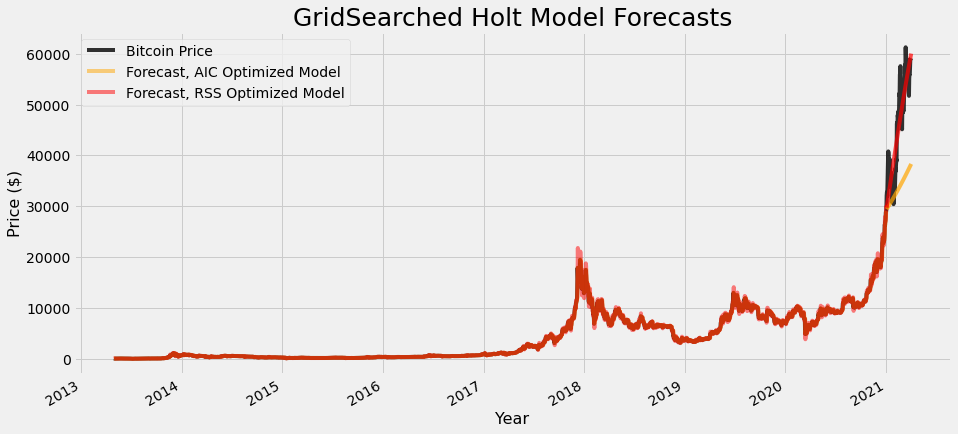

In [197]:
# plot true values
daily['close'].plot(alpha = 0.8, color='black', label='Bitcoin Price', legend=True, figsize=(14, 7))

# plot the fitted values
holt_aic.fittedvalues.plot(alpha=0.5, color='orange')
holt_rss.fittedvalues.plot(alpha=0.5, color='red')

# plot forecasted values
fcast_aic.plot(alpha=0.7, color='orange', label='Forecast, AIC Optimized Model', legend=True)
fcast_rss.plot(alpha=0.7, color='red', label='Forecast, RSS Optimized Model', legend=True)

# set title/x/y labels
plt.title('GridSearched Holt Model Forecasts', fontsize=25)
plt.xlabel('Year', fontsize=16)
plt.ylabel('Price ($)', fontsize=16);

In the above graph, it is clear that the forecasted price of the RSS optimized Holt model is a significant improvement over any model that has been previously created. Even the forecast for the AIC optimized Holt model is much better than any of the ARIMA/SARIMA models' forecasts. 

The choice to include the `fittedvalues` in this graph was to help better visualize the AIC score. At the beginning of 2018, there are a few values that were fit for the RSS model that were not Bitcoin's actual price during that time. This can be seen with the red shaded area that is just above and below the darker red area. The dark red area coincides with the true Bitcoin price. The worse AIC score in the RSS model is defined by these extra shaded areas. Based on a majority of the fitted values being within the range of the true values, this visualization confirms that trading off some AIC for RSS is a valid choice.

<a id="4"></a>
## Baseline Triple Exponential Smoothing Model
---
This section will build out a triple exponential smoothing model (Holt-Winters Exponential Smoothing). Similar to the previous section, this baseline model will be compared with the other baseline models.

The baseline parameters being checked are seasonal_period:30, trend: multiplicative, seasonal trend: additive, and damped: true. Seasonal period was established at the monthly level. The trend will be set to multiplicative even though the Holt model gridsearch returned additive as the best parameter - the data trend has not changed and could perform better in this model type so that is where the search will begin. Seasonal trend has not been established but will start with additive as the seasonality may not be as strong as the EDA suggests. Finally, damped is set to true as the expectation is if it is set to false the forecast will run up to infinity.

In [198]:
# insatiate and fit the baseline model
baseline_hw = ExponentialSmoothing(train, 
                                  seasonal_periods=30,
                                  trend='mul',
                                  seasonal='add',
                                  damped=True).fit()

# print aic score
print(f'Baseline Holt Winter Model AIC Score: {baseline_hw.aic}')

# generate forecasts for this model
baseline_hw_fcast = baseline_hw.forecast(len(test))

# print RSS score
print(f'Baseline Holt Winter Model RSS Score: {metrics.mean_squared_error(test, baseline_hw_fcast) * len(test)}')

Baseline Holt Winter Model AIC Score: 31594.712991325876
Baseline Holt Winter Model RSS Score: 1777842238.3718455


The baseline triple exponential smoothing model (Holt Winter's Model - HW) showed an improvement in RSS score from the baseline Holt model, however it is not an improvement on the best Holt model. Exploring the parameters that were selected and one more could provide a model that is even better than what has been created.

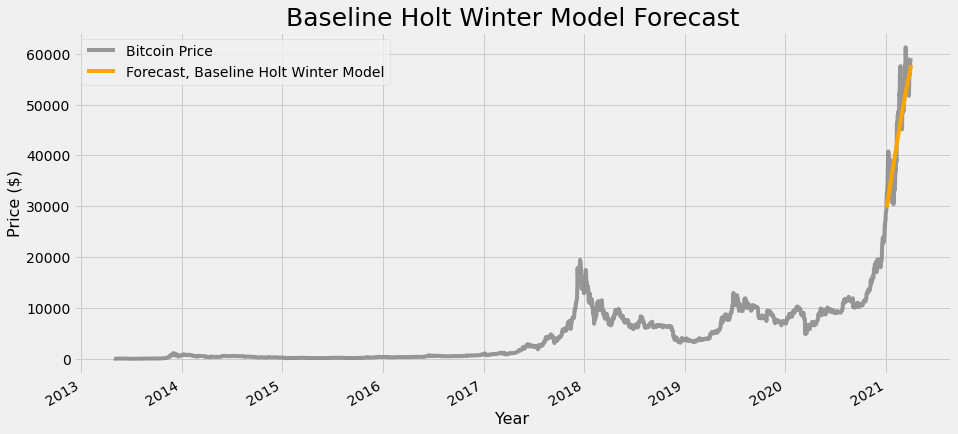

In [199]:
# plot true values
daily['close'].plot(alpha = 0.8, color='grey', label='Bitcoin Price', legend=True, figsize=(14, 7))

# plot forecasted values
baseline_hw_fcast.plot(color='orange', label='Forecast, Baseline Holt Winter Model', legend=True)

# add title/x/y labels
plt.title('Baseline Holt Winter Model Forecast', fontsize=25)
plt.xlabel('Year', fontsize=16)
plt.ylabel('Price ($)', fontsize=16);

The baseline HW model shows a much cleaner forecast when compared to the baseline Holt model's forecast. Instead of overestimating the price of Bitcoin, it looks like the HW model is slightly underestimating the price. The happy medium may be found through a quick gridsearch over the model's hyperparameters. 

<a id="5"></a>
## Triple Exponential Smoothing Model GridSearch

___
This section built a helper function that will GridSearch over the Holt Winter model's hyperparameters. This function will be used twice: once to optimize for AIC and once to optimize for RSS. 

The parameters being searched over in this gridsearch are trend, seasonal trend, damped, boxcox, and seasonal periods. The trend tells the model if the data has an exponential or linear trend. Seasonal trend tells the model what type of trend the seasonality component of the data has (this is similar to the seasonal order in the SARIMA model). Damped will allow the model's forecasts to eventually even out. Boxcox is a keyword argument used in the fitting process to perform a BoxCox transformation on the data. Seasonal periods are the level in which seasonality is found.  

In [200]:
#params of holt winter: keep optimized True and initialization method estimated (default)
seasonal = trend = ['add', 'mul']
damped_trend = use_boxcox = [True, False]
seasonal_periods = [None, 30, 90]

# function to gridsearch holt winter hyperparams and optimize for aic
def hw_gs(train, test, optimization = 'AIC'):
    
    # set initial values
    best_aic = 1000000000000000000
    best_rss = 1000000000000000000
    best_seasonal = ''
    best_trend = ''
    best_damped = True
    best_boxcox = True
    seasonal_period = _
    
    # set optimization condition
    if optimization == 'AIC':
    
        # loop through each seasonal val
        for sea in seasonal:

            # loop through each trend val
            for t in trend:

                # loop through damped val
                for d in damped_trend:

                    # loop through boxcox val
                    for b in use_boxcox:

                        # loop through seasonal periods
                        for s in seasonal_periods:

                            # set up try and except
                            try:

                                # insatiate and fit model
                                model = ExponentialSmoothing(train,
                                                             seasonal_periods = s,
                                                             trend=t,
                                                             seasonal=sea,
                                                             damped=d
                                                            ).fit(use_boxcox=b)

                                # generate forecast
                                fcast = model.forecast(len(test))

                                # generate error term
                                rss = metrics.mean_squared_error(test, fcast) * len(test)

                                # conditional to measure model
                                if model.aic < best_aic:
                                    best_aic = model.aic
                                    best_rss = rss
                                    best_seasonal = sea
                                    best_trend = t
                                    best_damped = d
                                    best_boxcox = b
                                    seasonal_period = s

                                # print statement for each model
                                print(f'HW model params: seasonal {sea}, trend {t}, damped {d}, boxcox {b}, seasonal period {s} with RSS of {rss} and AIC of {model.aic}')

                            except:
                                continue

        # print best params and the AIC / RSS of the model
        print(f'The HW model that optimized for AIC was seasonal {best_seasonal}, trend {best_trend}, damped {best_damped}, boxcox {best_boxcox}, seasonal period {seasonal_period} with RSS of {best_rss} and AIC of {best_aic}')
        
    # set RSS condition
    elif optimization == 'RSS':
        
        # loop through each seasonal val
        for sea in seasonal:

            # loop through each trend val
            for t in trend:

                # loop through damped val
                for d in damped_trend:

                    # loop through boxcox val
                    for b in use_boxcox:

                        # loop through seasonal periods
                        for s in seasonal_periods:

                            # set up try and except
                            try:

                                # insatiate and fit model
                                model = ExponentialSmoothing(train,
                                                             seasonal_periods = s,
                                                             trend=t,
                                                             seasonal=sea,
                                                             damped=d
                                                            ).fit(use_boxcox=b)

                                # generate forecast
                                fcast = model.forecast(len(test))

                                # generate error term
                                rss = metrics.mean_squared_error(test, fcast) * len(test)

                                # conditional to measure model
                                if rss < best_rss:
                                    best_aic = model.aic
                                    best_rss = rss
                                    best_seasonal = sea
                                    best_trend = t
                                    best_damped = d
                                    best_boxcox = b
                                    seasonal_period = s

                                # print statement for each model
                                print(f'HW model params: seasonal {sea}, trend {t}, damped {d}, boxcox {b}, seasonal period {s} with RSS of {rss} and AIC of {model.aic}')

                            except:
                                continue

        # print best params and the AIC / RSS of the model
        print(f'The HW model that optimized for RSS was seasonal {best_seasonal}, trend {best_trend}, damped {best_damped}, boxcox {best_boxcox}, seasonal period {seasonal_period} with RSS of {best_rss} and AIC of {best_aic}')
        
    else:
        print('Optimization Metric Not Valid, please select either AIC or RSS')

In [209]:
### GRIDSEARCH CELL

# hw_gs(train, test)

# OUTPUT: 
# The HW model that optimized for AIC was seasonal mul, trend mul, damped False, boxcox True, 
# seasonal period 30 with RSS of 20400967764.329018 and AIC of 31504.365238411654

In [208]:
### GRIDSEARCH CELL 

# hw_gs(train, test, 'RSS')

# OUTPUT: 
# The HW model that optimized for RSS was seasonal add, trend mul, damped True, boxcox False, 
# seasonal period 30 with RSS of 1777842238.3718455 and AIC of 31594.712991325876

The two different Holt Winter's Exponential Smoothing GridSearch's provided the following outputs:

    Optimizing for AIC: `The HW model that optimized for AIC was seasonal mul, trend mul, damped False, boxcox True, seasonal period 30 with RSS of 20,400,967,764.329018 and AIC of 31,504.365238411654`
    
    Optimizing for RSS: `The HW model that optimized for RSS was seasonal add, trend mul, damped True, boxcox False, seasonal period 30 with RSS of 1,777,842,238.3718455 and AIC of 31,594.712991325876`
    
The expectation was that the HW model would return a more favorable RSS score than what it ended up returning. After running the gridsearch to optimize the model based on teh RSS, the gridsearch returned the baseline hyperparamters - after eight different gridsearches it was bound to happen!

In [203]:
# insatiate and fit aic model
hw_aic = ExponentialSmoothing(train,
                              seasonal = 'mul',
                              trend = 'mul',
                              damped_trend = False,
                              seasonal_periods = 30).fit(use_boxcox=True)
                              
# generate forcast from this model
hw_fcast_aic = hw_aic.forecast(len(test))

In [204]:
# insatiate and fit aic model
hw_rss = ExponentialSmoothing(train,
                              seasonal = 'add',
                              trend = 'mul',
                              damped_trend = True,
                              seasonal_periods = 30).fit(use_boxcox=False)
                              
# generate forcast from this model
hw_fcast_rss = hw_rss.forecast(len(test))

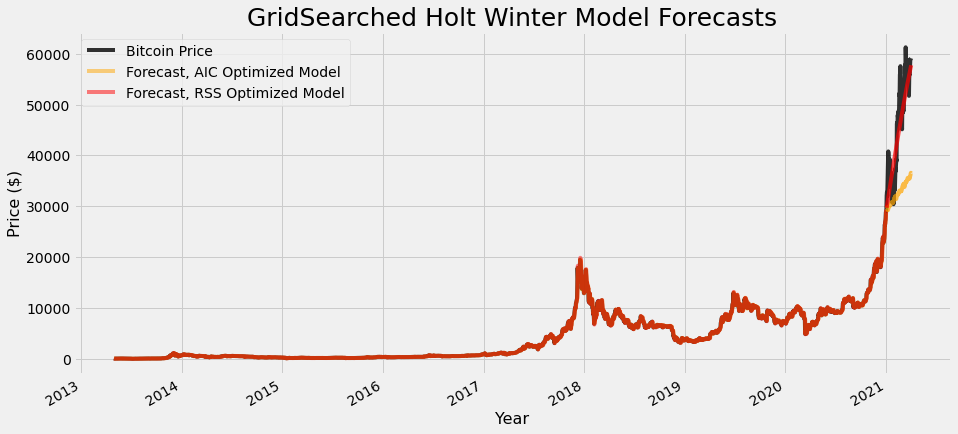

In [205]:
# plot true values
daily['close'].plot(alpha = 0.8, color='black', label='Bitcoin Price', legend=True, figsize=(14, 7))

# plot the fitted values
hw_aic.fittedvalues.plot(alpha=0.5, color='orange')
hw_rss.fittedvalues.plot(alpha=0.5, color='red')

# plot forecasted values
hw_fcast_aic.plot(alpha=0.7, color='orange', label='Forecast, AIC Optimized Model', legend=True)
hw_fcast_rss.plot(alpha=0.7, color='red', label='Forecast, RSS Optimized Model', legend=True)

# set title/x/y labels
plt.title('GridSearched Holt Winter Model Forecasts', fontsize=25)
plt.xlabel('Year', fontsize=16)
plt.ylabel('Price ($)', fontsize=16);

In the above graph, it is clear that the forecasted price of the RSS optimized Holt Winter model is significantly better than the AIC optimized model. This has been the case for every model type that has been checked, signalling the importance of optimizing for RSS over AIC. 

The choice to include the `fittedvalues` in this graph was to help better visualize the AIC score. Unlike in the Holt model where some red shaded areas could be seen around 2018, the slightly improved AIC score had even less shaded areas suggesting the Holt Winter model had a better training score. 

After running 8 different types of gridsearches, the following results have been collected:

| Model | Optimized | AIC | RSS |
|--|--|--|--|
| ARIMA | AIC | -9,803.978875555455 | 195,663,055,382.6728 |
| ARIMA | RSS | -9,763.586525933988 | 18,940,753,598.031494 |
| SARIMA | AIC | -9,775.04078021729 | 24,573,606,014.329235 |
| SARIMA | RSS | -8,821.249991627563 | 7,395,120,381.605706 |
| Holt | AIC | 31,511.65372812618 | 17,592,924,408.176796 |
| Holt | RSS | 32,622.519073158164 | 1,649,003,709.904847 |
| Holt Winter | AIC | 31,504.365238411654 | 20,400,967,764.329018 |
| Holt Winter | RSS | 31,594.712991325876 | 1,777,842,238.3718455 |

Based on this finding, there is an interesting conclusion that can be drawn: the seasonality found in Bitcoin is specific to pullbacks only. The way this conclusion is drawn is based on how the exponential models forecast compared to how the SARIMA model forecasts. The exponential models are forecasting an exponential trend and are not concerned with minor pullbacks when the long-term trend is higher. As a result, the exponential model that incorporates seasonality is not helpful because the seasonality is refelctive of short-term declines/pullbacks.

Another key point to highlight is that both of the RSS optimized Exponential models (Holt / Holt Winter) fit the criteria for a reasonable error level. The next section will forecast the price of Bitcoin on July 1, 2021.

<a id="5"></a>
## Forward Forecast: Holt Model
___
This section rebuilds the RSS optimized Holt model to generate forecasts for the next quarter. Rather than run a forward forecast on both the Holt and Holt Winter model's the Holt is the one selected because it has the lower error value.

Below a quick check of the root mean squared error (RMSE) will be done in order to confirm that its value is below the 6,300 threshold established in the problem statement.

There is a large assumption here which is the RSS optimized Holt model's parameters are the optimial parameters for the full dataset. 

In [216]:
# calculate RMSE for the holt model optimized for RSS to confirm it is below 6300
metrics.mean_squared_error(test, fcast_rss, squared=False)

4280.4513130495

In [217]:
# rebuild the holt rss model except use all of the data to train the model
holt_rss_full = Holt(daily['close'],
                exponential=True,
                damped_trend=True,
                initialization_method='estimated').fit(0.894736842105263, 0.7894736842105263, optimized=True)

In [219]:
# forecast the next 90 days of Bitcoin price
july_fcast = holt_rss_full.forecast(90)

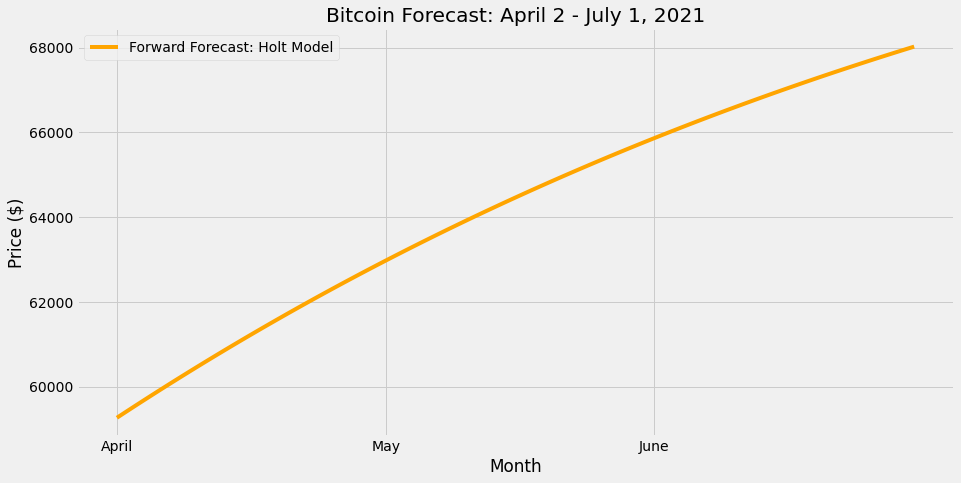

In [251]:
# show the forecasted price
july_fcast.plot(color='orange', label='Forward Forecast: Holt Model', figsize=(14,7), legend=True)

# set title/x/y labels
plt.title('Bitcoin Forecast: April 2 - July 1, 2021')
plt.ylabel('Price ($)')
plt.xlabel('Month')
plt.xticks(ticks=np.arange(july_fcast.index[0], july_fcast.index[-1], 30), labels=['April', 'May', 'June']);

In [250]:
list(july_fcast)[-1]

68023.95454985427

Based on the above graph, the Holt model is beginning to damped the trend and cause the forecast to level off. This is what should be expected of the price of Bitcoin, the question is will this price stagnation occur this summer or later down the line.

Based on this model, the forecasted price of Bitcoin on July 1, 2021 is $68,023.95 +/- $4,280.45. While extremely promising, this forecast could be improved with a neural network which will be explored next.